In [126]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = Path("round-3-island-data-bottle")

In [12]:
if file_path.exists():
    # Read the CSV file
    df_day_0 = pd.read_csv(
        file_path / "trades_round_3_day_0_nn.csv", delimiter=";"
    )  # day 0
    df_day_1 = pd.read_csv(
        file_path / "trades_round_3_day_1_nn.csv", delimiter=";"
    )  # day 1
    df_day_2 = pd.read_csv(
        file_path / "trades_round_3_day_2_nn.csv", delimiter=";"
    )  # day 2
    print("File loaded successfully.")
else:
    print("File not found. Please ensure the file exists at:", file_path)

df_day_0["timestamp"] = pd.to_numeric(df_day_0["timestamp"])
df_day_1["timestamp"] = pd.to_numeric(df_day_1["timestamp"])
df_day_2["timestamp"] = pd.to_numeric(df_day_2["timestamp"])

# df_day_1["timestamp"] += 999801
# df_day_2["timestamp"] += 999701

# df_day_min_1["DAY"] = "day_-1"
# df_day_0["DAY"] = "day_0"
# df_day_plus_1["DAY"] = "day_+1"

# day_to_num = {"day_-1": -1, "day_0": 0, "day_+1": 1}


# df = pd.concat([df_day_0, df_day_1, df_day_2], ignore_index=True)

File loaded successfully.


In [14]:
df_day_0.head(10)

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,CHOCOLATE,SEASHELLS,8001.0,8
1,0,NaN,NaN,ROSES,SEASHELLS,15001.0,3
2,200,NaN,NaN,ROSES,SEASHELLS,15000.0,3
3,500,NaN,NaN,STRAWBERRIES,SEASHELLS,3999.0,10
4,1000,NaN,NaN,GIFT_BASKET,SEASHELLS,71360.0,2
5,1200,NaN,NaN,ROSES,SEASHELLS,14997.0,1
6,1300,NaN,NaN,CHOCOLATE,SEASHELLS,8000.0,7
7,1400,NaN,NaN,ROSES,SEASHELLS,14994.0,3
8,2600,NaN,NaN,ROSES,SEASHELLS,14974.0,5
9,2800,NaN,NaN,STRAWBERRIES,SEASHELLS,4001.0,10


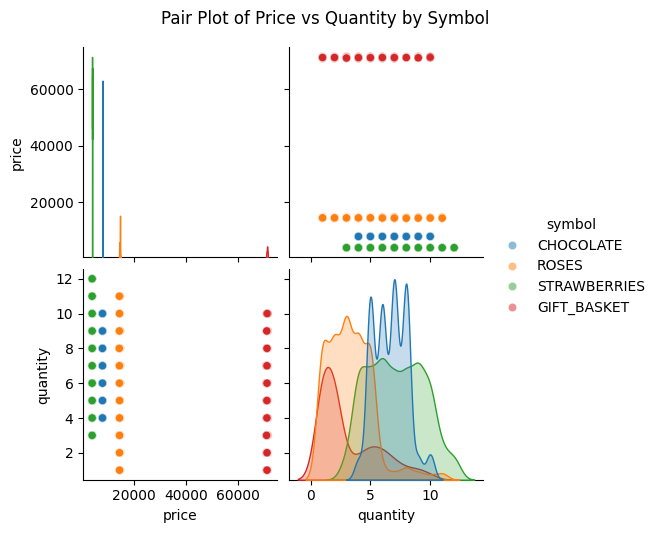

In [61]:
# Create a pair plot
pair_plot = sns.pairplot(
    df_day_0, vars=["price", "quantity"], hue="symbol", plot_kws={"alpha": 0.5}
)
pair_plot.fig.suptitle("Pair Plot of Price vs Quantity by Symbol", y=1.05)
plt.show()

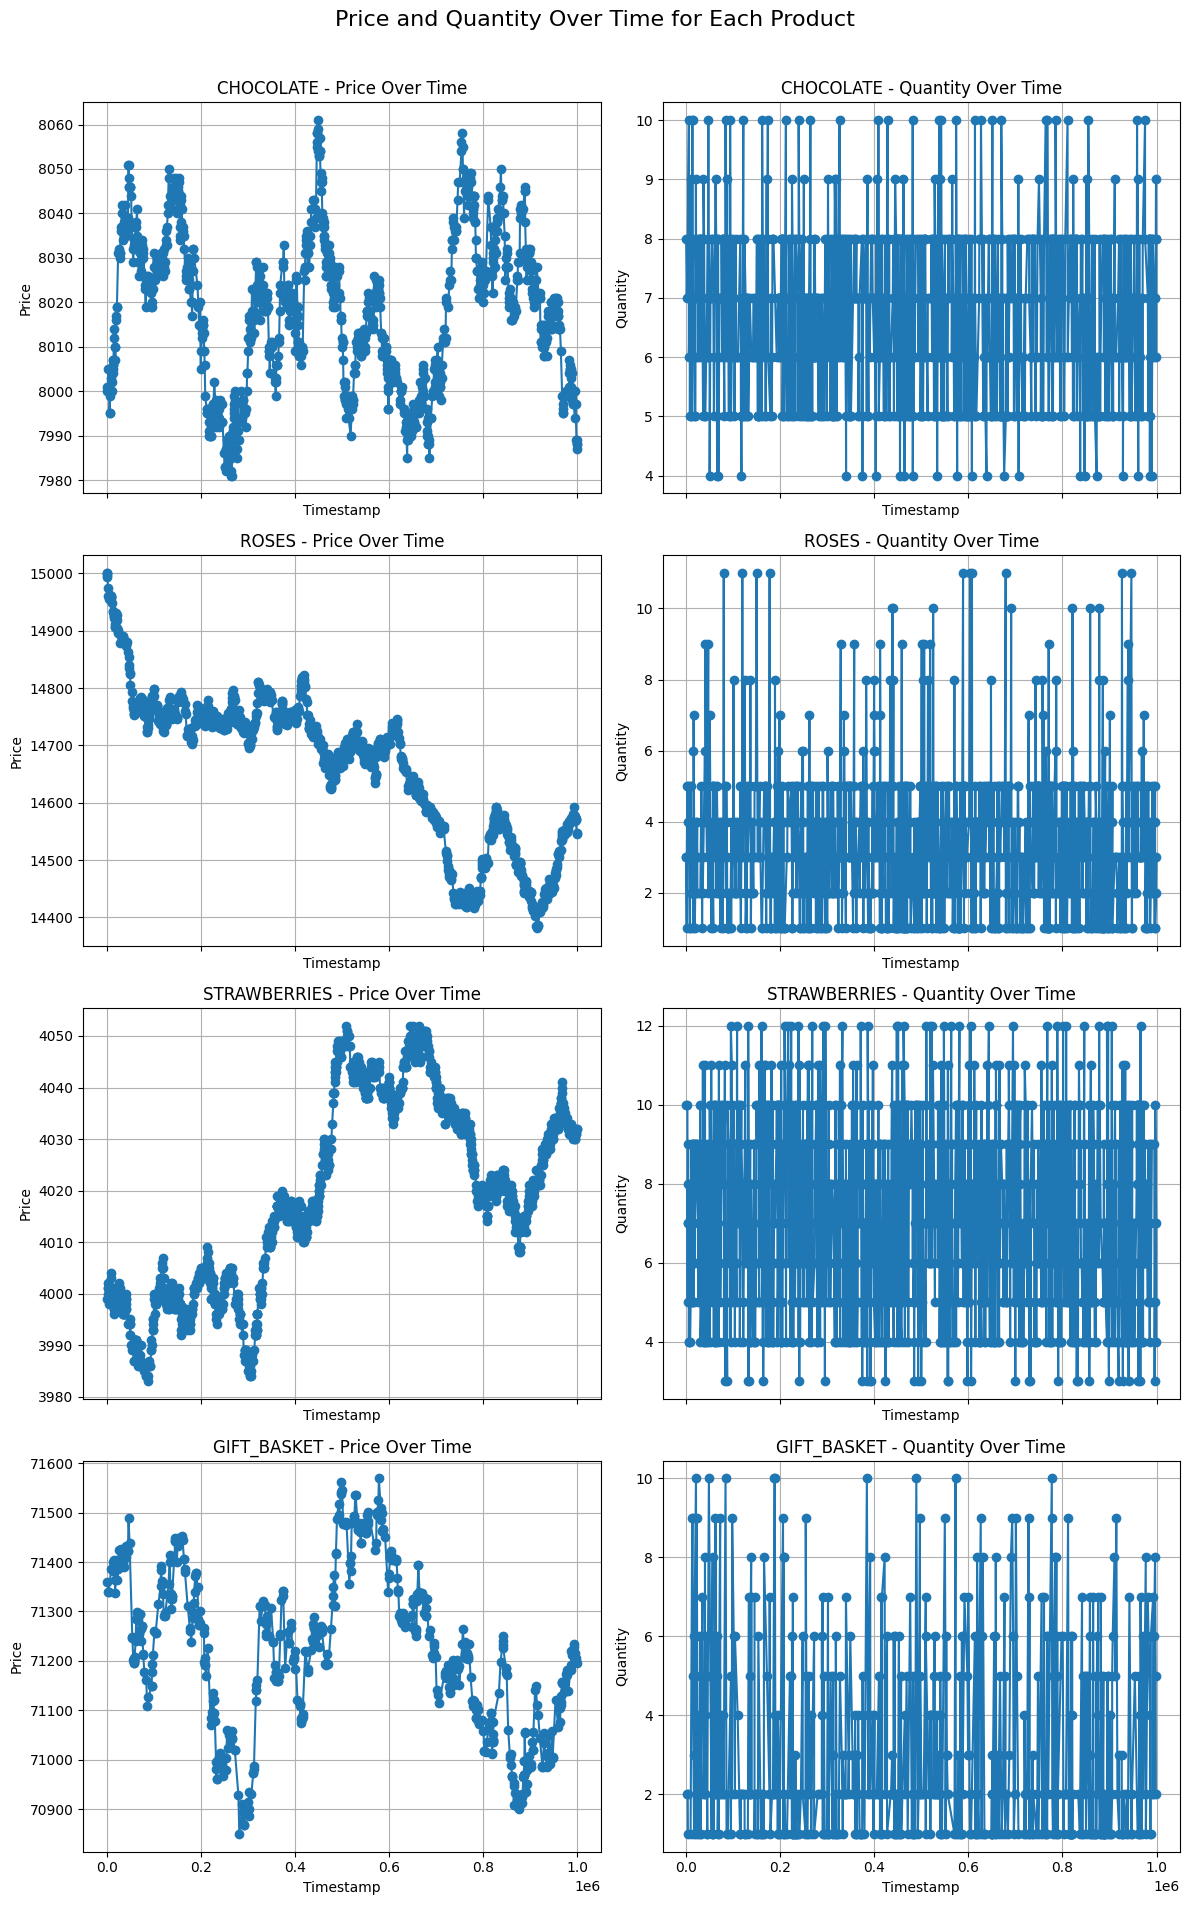

In [16]:
unique_symbols = df_day_0["symbol"].unique()
fig, axes = plt.subplots(
    nrows=len(unique_symbols),
    ncols=2,
    figsize=(12, 5 * len(unique_symbols)),
    sharex="col",
)
fig.suptitle("Price and Quantity Over Time for Each Product", fontsize=16)

for index, symbol in enumerate(unique_symbols):
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Plotting price over time
    ax1 = axes[index, 0]
    ax1.plot(symbol_data["timestamp"], symbol_data["price"], marker="o", linestyle="-")
    ax1.set_title(f"{symbol} - Price Over Time")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Price")
    ax1.grid(True)

    # Plotting quantity over time
    ax2 = axes[index, 1]
    ax2.plot(
        symbol_data["timestamp"], symbol_data["quantity"], marker="o", linestyle="-"
    )
    ax2.set_title(f"{symbol} - Quantity Over Time")
    ax2.set_xlabel("Timestamp")
    ax2.set_ylabel("Quantity")
    ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

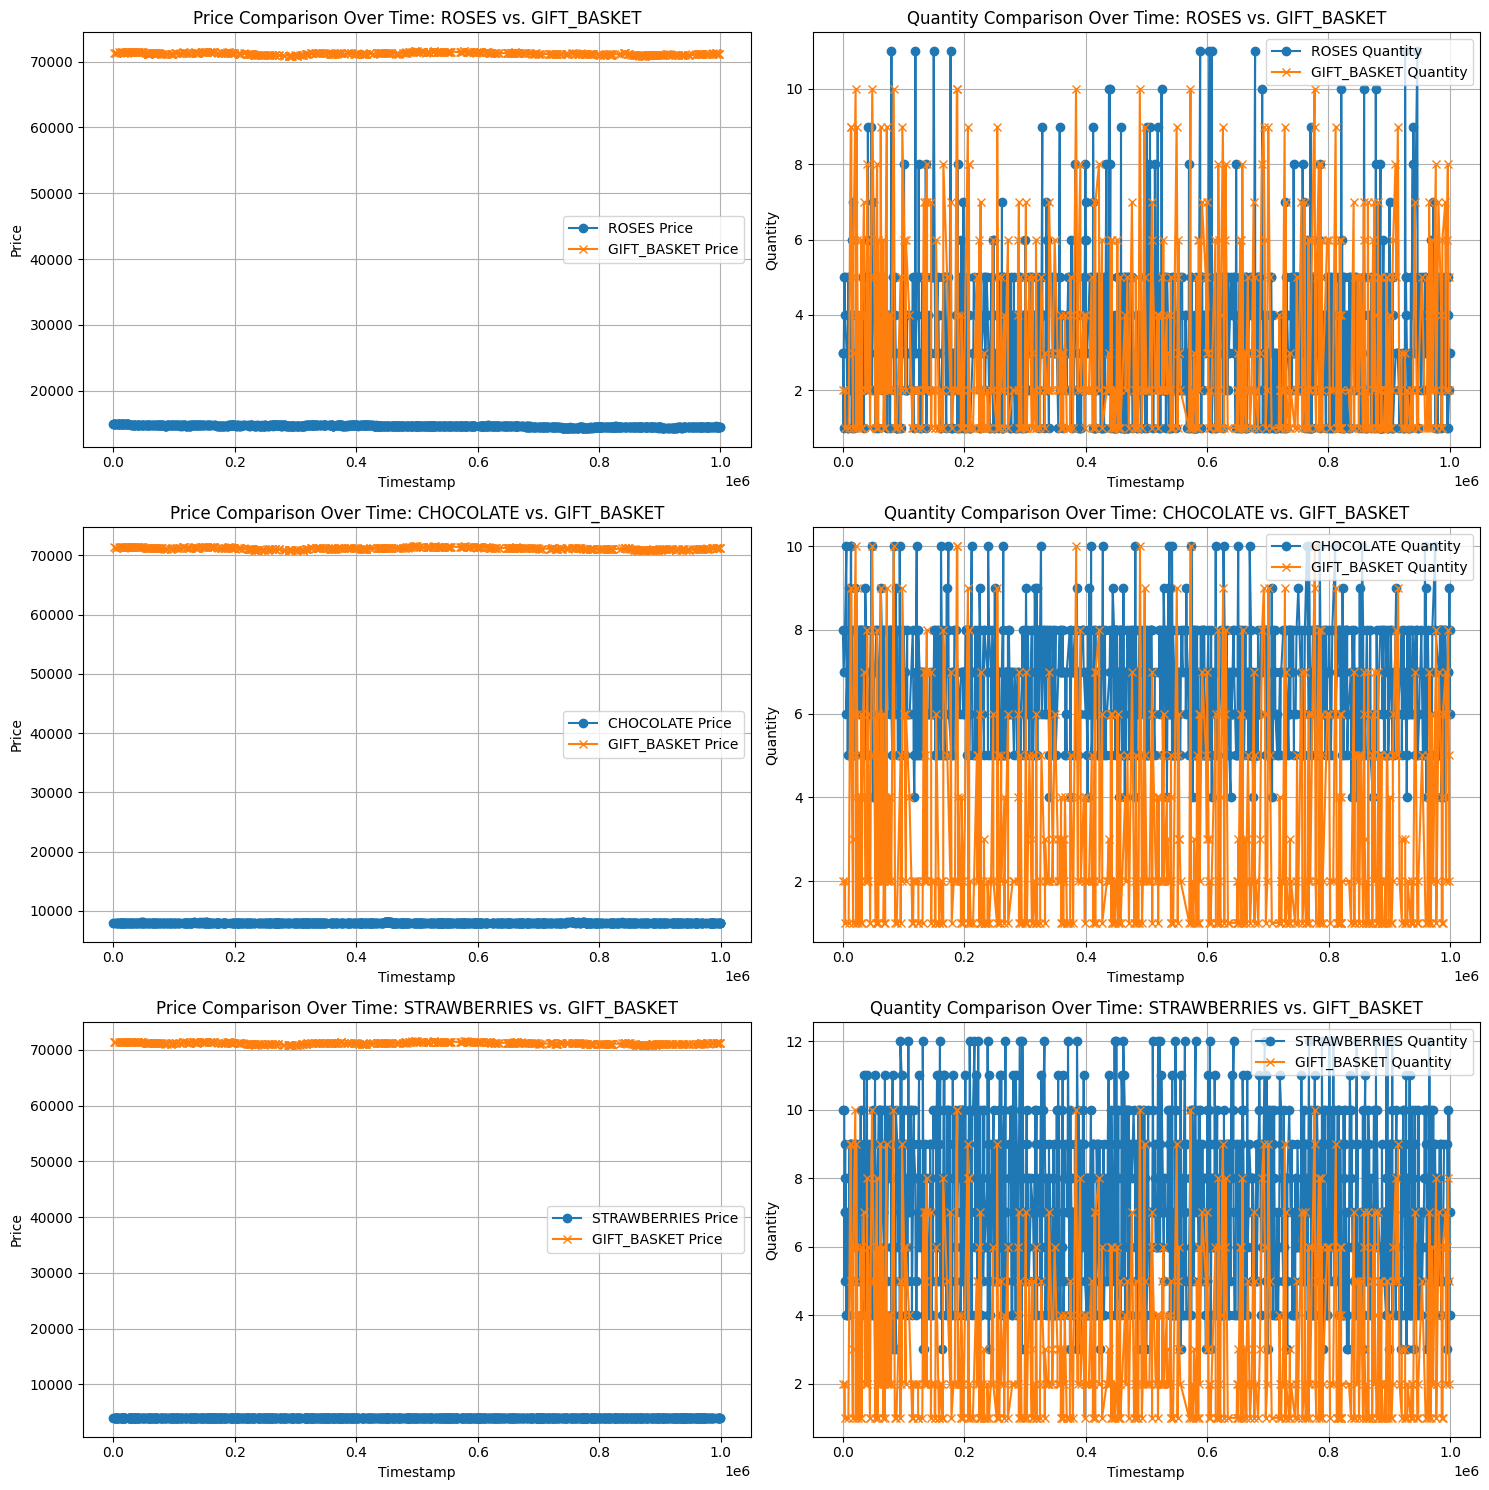

In [19]:
# Correcting variable name and selecting symbols to compare
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Creating plots
fig, axs = plt.subplots(
    len(symbols_to_compare), 2, figsize=(15, 5 * len(symbols_to_compare))
)

for index, symbol in enumerate(symbols_to_compare):
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Price plot
    axs[index, 0].plot(
        symbol_data["timestamp"],
        symbol_data["price"],
        label=f"{symbol} Price",
        marker="o",
    )
    axs[index, 0].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["price"],
        label=f"{base_symbol} Price",
        marker="x",
    )
    axs[index, 0].set_title(f"Price Comparison Over Time: {symbol} vs. {base_symbol}")
    axs[index, 0].set_xlabel("Timestamp")
    axs[index, 0].set_ylabel("Price")
    axs[index, 0].legend()
    axs[index, 0].grid(True)

    # Quantity plot
    axs[index, 1].plot(
        symbol_data["timestamp"],
        symbol_data["quantity"],
        label=f"{symbol} Quantity",
        marker="o",
    )
    axs[index, 1].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["quantity"],
        label=f"{base_symbol} Quantity",
        marker="x",
    )
    axs[index, 1].set_title(
        f"Quantity Comparison Over Time: {symbol} vs. {base_symbol}"
    )
    axs[index, 1].set_xlabel("Timestamp")
    axs[index, 1].set_ylabel("Quantity")
    axs[index, 1].legend()
    axs[index, 1].grid(True)

plt.tight_layout()
plt.show()

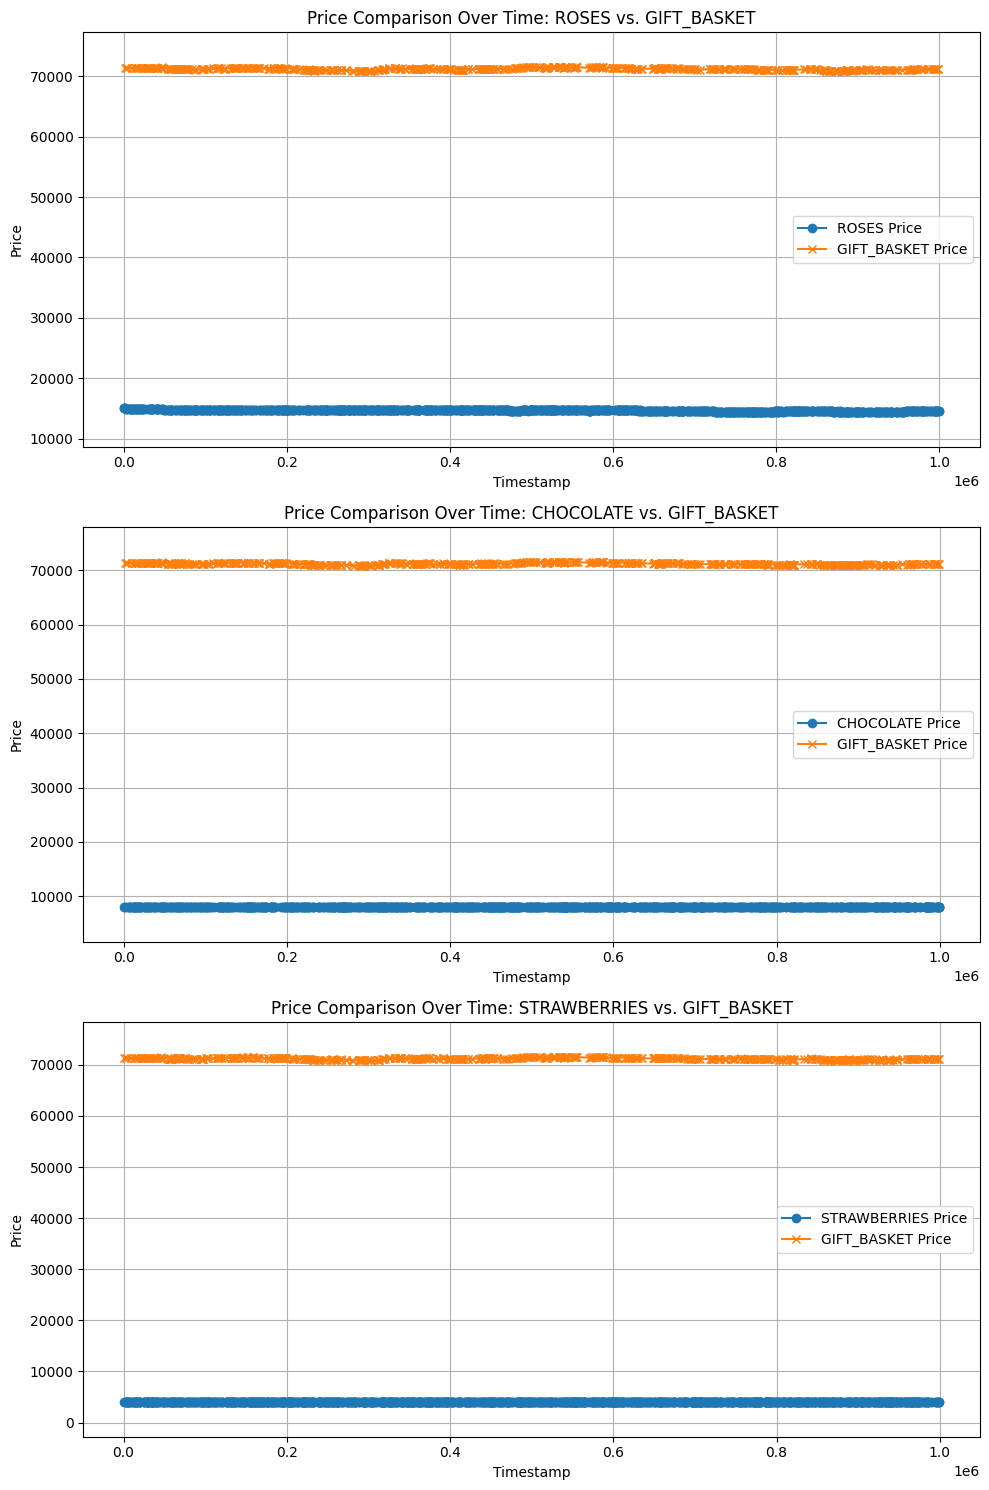

In [23]:
# Defining symbols to compare and the base symbol
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Creating a single plot for price comparison
fig, axs = plt.subplots(
    len(symbols_to_compare), 1, figsize=(10, 5 * len(symbols_to_compare))
)

for index, symbol in enumerate(symbols_to_compare):
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Compute price limits for the y-axis
    min_price = min(symbol_data["price"].min(), gift_basket_data["price"].min())
    max_price = max(symbol_data["price"].max(), gift_basket_data["price"].max())
    price_pad = (max_price - min_price) * 0.1  # adding 10% padding

    # Price plot
    axs[index].plot(
        symbol_data["timestamp"],
        symbol_data["price"],
        label=f"{symbol} Price",
        marker="o",
    )
    axs[index].plot(
        gift_basket_data["timestamp"],
        gift_basket_data["price"],
        label=f"{base_symbol} Price",
        marker="x",
    )
    axs[index].set_title(f"Price Comparison Over Time: {symbol} vs. {base_symbol}")
    axs[index].set_xlabel("Timestamp")
    axs[index].set_ylabel("Price")
    axs[index].legend()
    axs[index].grid(True)
    axs[index].set_ylim(
        [min_price - price_pad, max_price + price_pad]
    )  # setting y-axis limits

plt.tight_layout()
plt.show()

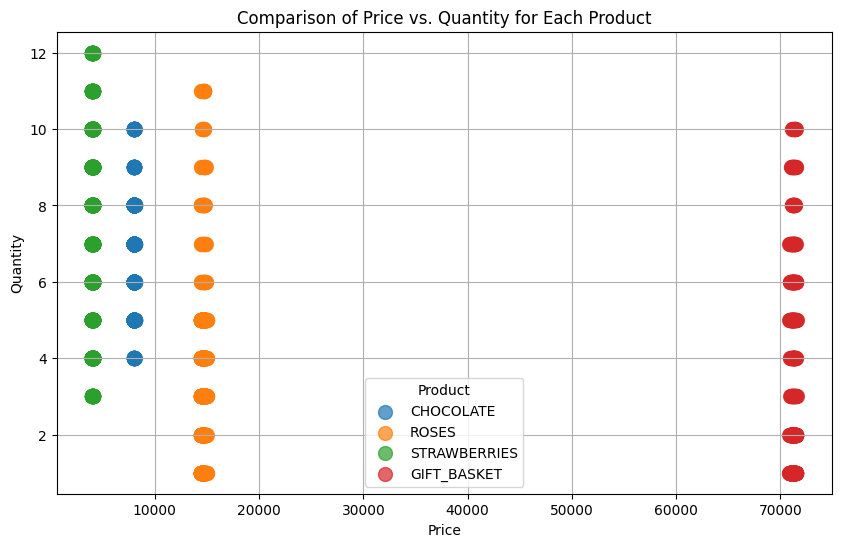

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
unique_symbols = df_day_0["symbol"].unique()

for symbol in unique_symbols:
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]
    ax.scatter(
        symbol_data["price"], symbol_data["quantity"], label=symbol, s=100, alpha=0.7
    )

ax.set_title("Comparison of Price vs. Quantity for Each Product")
ax.set_xlabel("Price")
ax.set_ylabel("Quantity")
ax.legend(title="Product")
ax.grid(True)

plt.show()

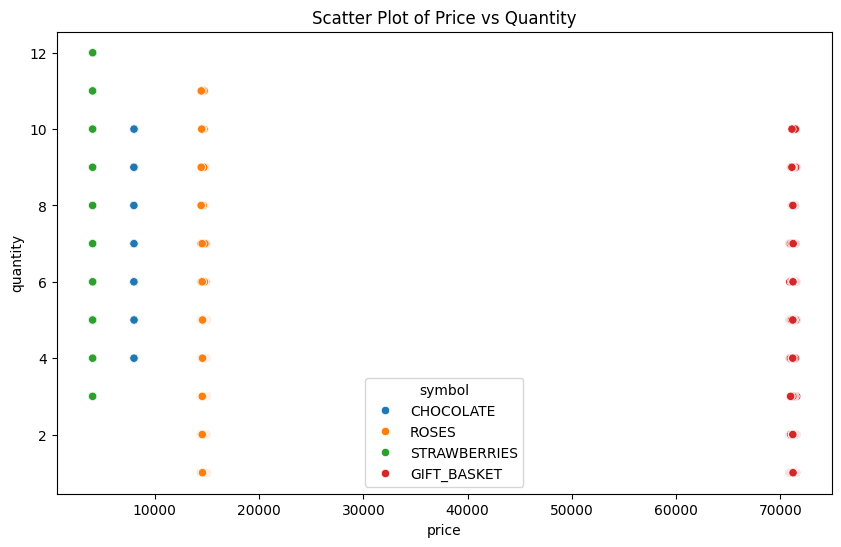

In [27]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="price", y="quantity", hue="symbol", data=df_day_0)
plt.title("Scatter Plot of Price vs Quantity")
plt.show()

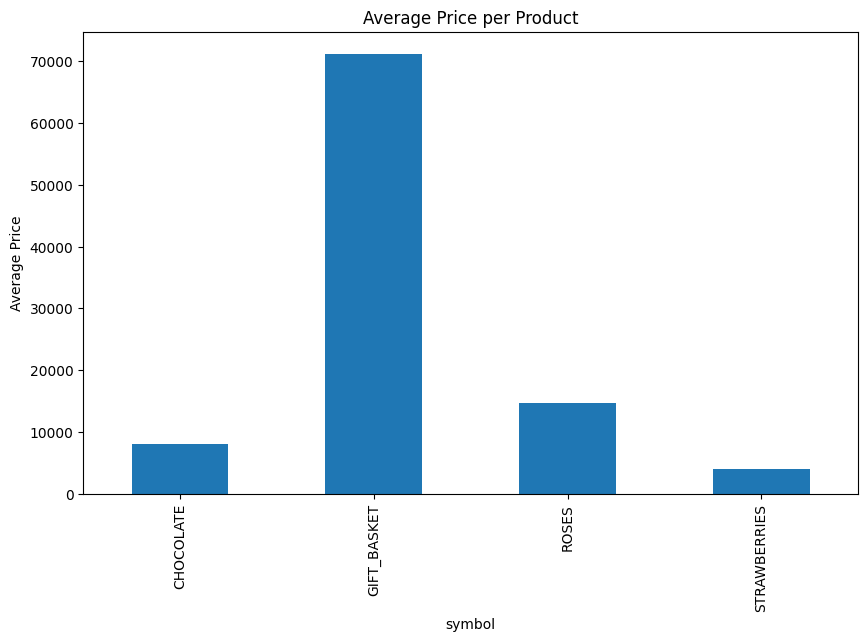

In [29]:
# Bar Chart
plt.figure(figsize=(10, 6))
df_day_0.groupby("symbol")["price"].mean().plot(kind="bar")
plt.title("Average Price per Product")
plt.ylabel("Average Price")
plt.show()

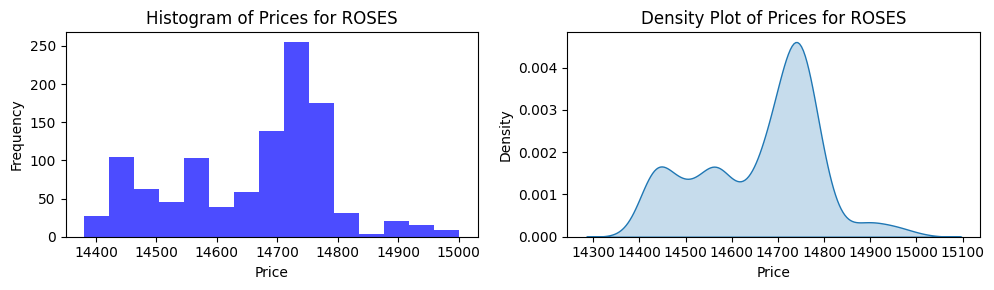

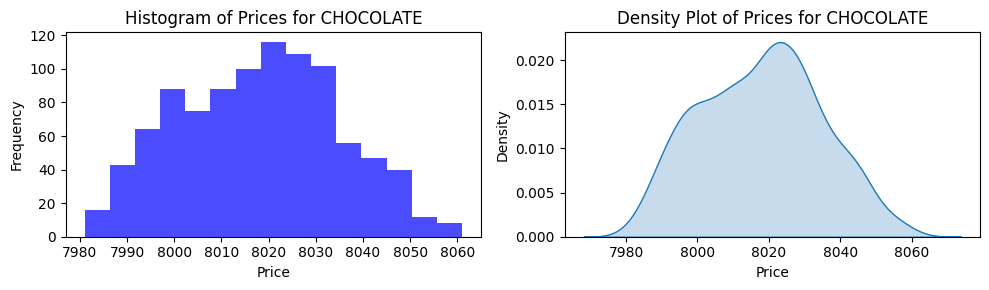

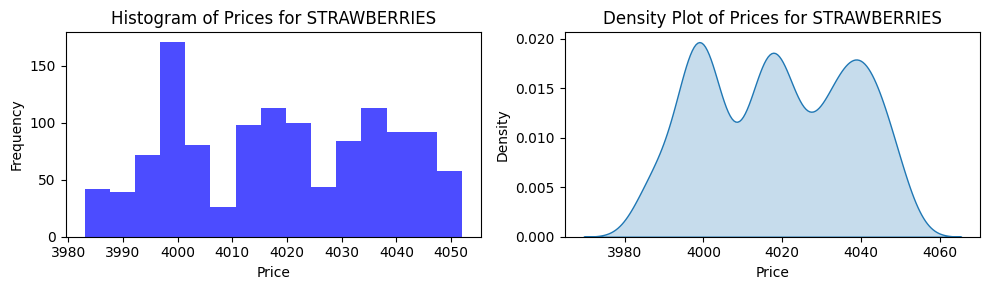

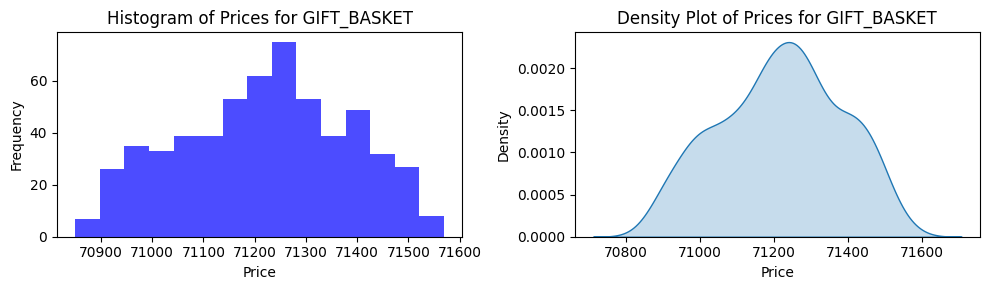

In [52]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

for symbol in symbols_to_compare:
    # Setup the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Histogram
    axs[0].hist(
        df_day_0[df_day_0["symbol"] == symbol]["price"],
        bins=15,
        alpha=0.7,
        color="blue",
    )
    axs[0].set_title(f"Histogram of Prices for {symbol}")
    axs[0].set_xlabel("Price")
    axs[0].set_ylabel("Frequency")

    # Density Plot
    sns.kdeplot(df_day_0[df_day_0["symbol"] == symbol]["price"], ax=axs[1], fill=True)
    axs[1].set_title(f"Density Plot of Prices for {symbol}")
    axs[1].set_xlabel("Price")

    plt.tight_layout()
    plt.show()

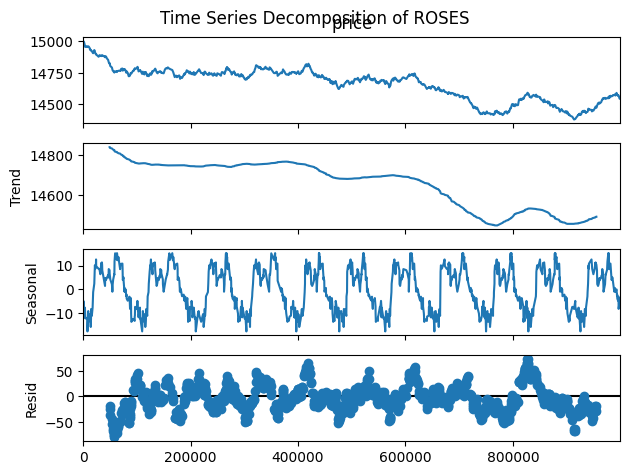

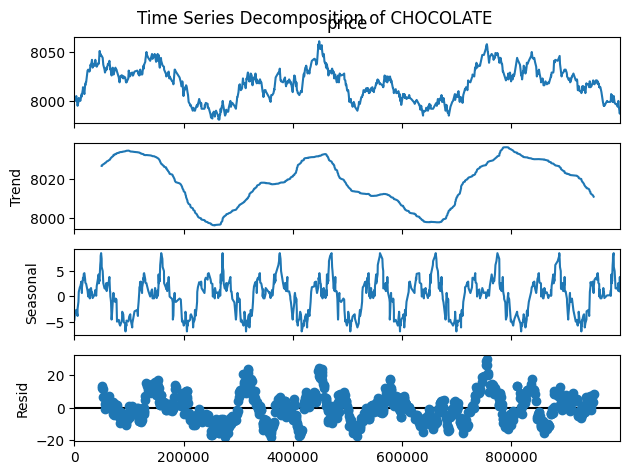

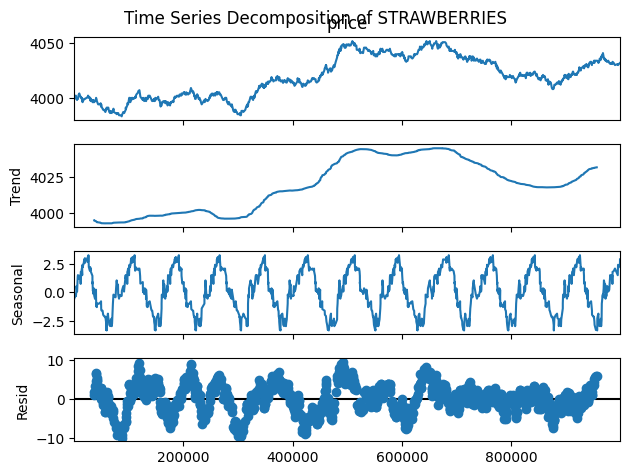

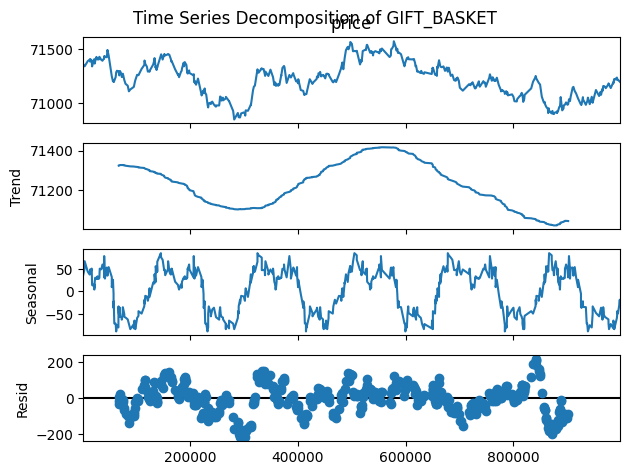

In [59]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

# Time Series Decomposition
for symbol in symbols_to_compare:
    series = df_day_0[df_day_0["symbol"] == symbol].set_index("timestamp")["price"]
    # Make sure there is more than one data point for decomposition
    if len(series) > 1:
        result = seasonal_decompose(series, model="additive", period=100)
        result.plot()
        plt.suptitle(
            f"Time Series Decomposition of {symbol}"
        )  # Using plt.suptitle to properly set the title
        plt.show()
    else:
        print(f"Not enough data for {symbol} to perform time series decomposition.")

Original: Shows the actual data.  
Trend: Shows the long-term movement in data, filtering out short-term fluctuations.  
Seasonal: Shows the repeating short-term pattern in the data.  
Resid (Residual): Shows the difference between the original series and the sum of the identified trend and seasonal components.


#### 1. Trend

A trend in a time series plot represents the long-term increase or decrease in the data. It shows a persistent, underlying movement in the data over time. This could be an upward, downward, or stable trend depending on how the data changes:

Upward Trend: The data points consistently increase over time.
Downward Trend: The data points consistently decrease over time.
Stable Trend: The data points do not show significant changes over time, staying relatively constant.

#### 2. Seasonality

Seasonality shows patterns that repeat over a known, fixed period. For example, ice cream sales might increase during summer months every year or retail sales spike during the holiday season. Seasonal effects are predictable and repeat in the same period every cycle, such as daily, monthly, or quarterly.

#### 3. Cyclic Changes

These are fluctuations that occur in the data that are not of a fixed period. These cycles can be caused by economic conditions like boom and bust cycles in an economy, which do not have a predictable pattern as seasonal effects do. They are often longer-term fluctuations compared to seasonal patterns.

#### 4. Irregular Component (Noise)

The irregular component consists of random fluctuations that do not form any pattern. These can be caused by unpredictable or random events and are usually impossible to predict in advance.

#### 5. Decomposition of Time Series

In the context of the Python seasonal_decompose method, the time series is broken down into three components: trend, seasonal, and residual. The residual component includes anything that is not explained by the trend and seasonal components and might include noise and cyclic variations if they are not part of the model used:

Trend Component: Extracted by smoothing or averaging the data over time.
Seasonal Component: Extracted by identifying and averaging the repeating short-term cycles in the data.
Residual Component: Obtained by removing the trend and seasonal components from the original data, showing what is left unexplained.


<Figure size 1000x600 with 0 Axes>

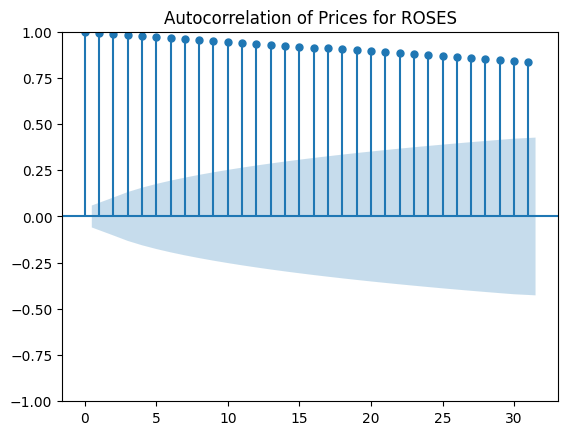

<Figure size 1000x600 with 0 Axes>

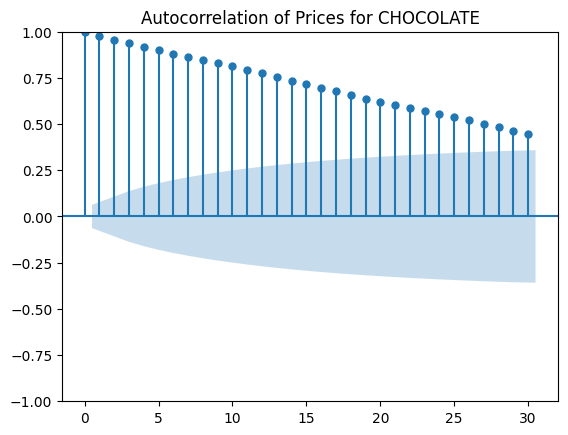

<Figure size 1000x600 with 0 Axes>

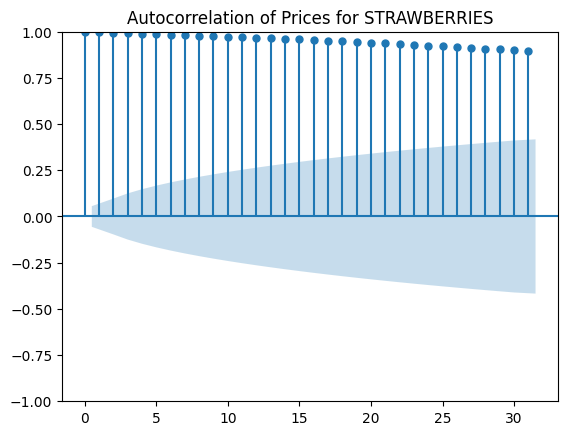

<Figure size 1000x600 with 0 Axes>

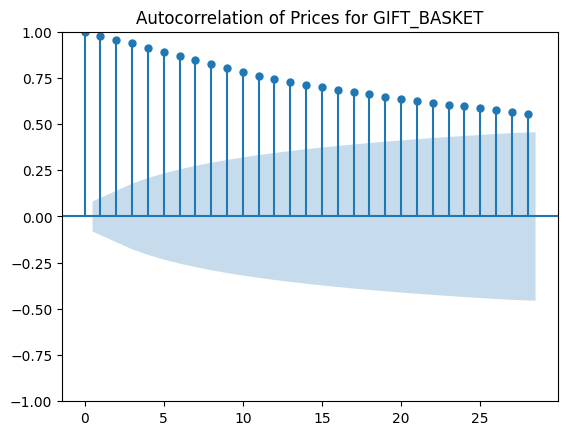

In [44]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES", "GIFT_BASKET"]

for symbol in symbols_to_compare:
    # Correlogram: Shows the autocorrelation function for the
    plt.figure(figsize=(10, 6))
    plot_acf(df_day_0[df_day_0["symbol"] == symbol]["price"])
    plt.title(f"Autocorrelation of Prices for {symbol}")
    plt.show()

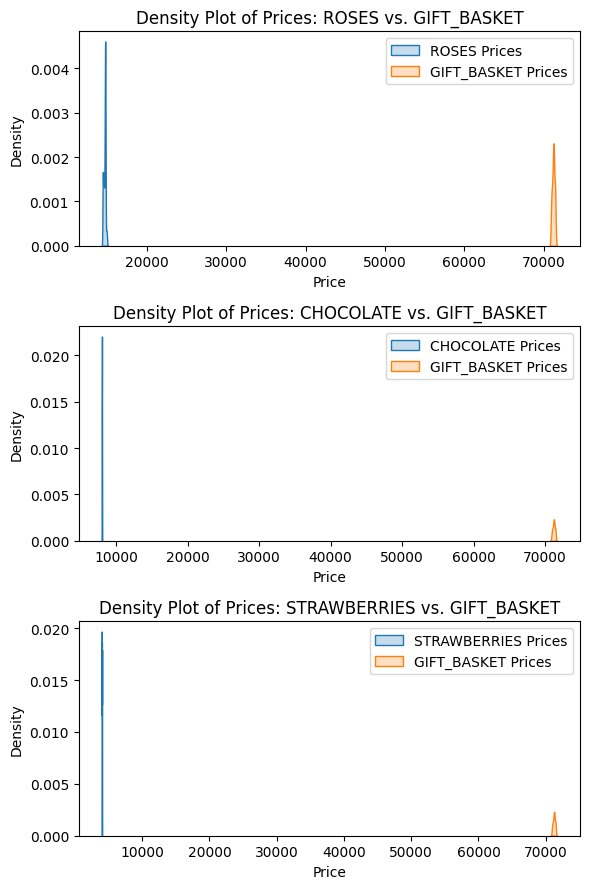

In [53]:
symbols_to_compare = ["ROSES", "CHOCOLATE", "STRAWBERRIES"]
base_symbol = "GIFT_BASKET"
gift_basket_data = df_day_0[df_day_0["symbol"] == base_symbol]

# Create a figure and axes with 1 column and a dynamic number of rows based on the symbol count
fig, axs = plt.subplots(
    nrows=len(symbols_to_compare), ncols=1, figsize=(6, 3 * len(symbols_to_compare))
)

# Ensure axs is always an array, even with one subplot
if len(symbols_to_compare) == 1:
    axs = [axs]

# Plot KDE for each symbol against GIFT_BASKET
for ax, symbol in zip(axs, symbols_to_compare):
    # Extract symbol data
    symbol_data = df_day_0[df_day_0["symbol"] == symbol]

    # Plot KDE for the symbol
    sns.kdeplot(symbol_data["price"], ax=ax, label=f"{symbol} Prices", fill=True)

    # Plot KDE for GIFT_BASKET
    sns.kdeplot(
        gift_basket_data["price"], ax=ax, label=f"{base_symbol} Prices", fill=True
    )

    ax.set_title(f"Density Plot of Prices: {symbol} vs. {base_symbol}")
    ax.set_xlabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()

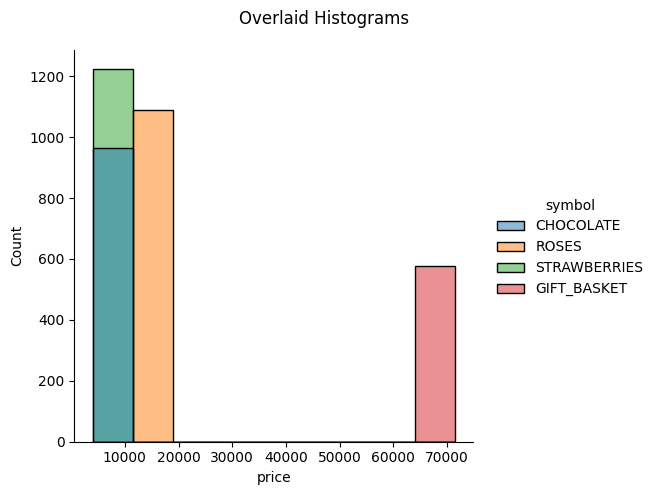

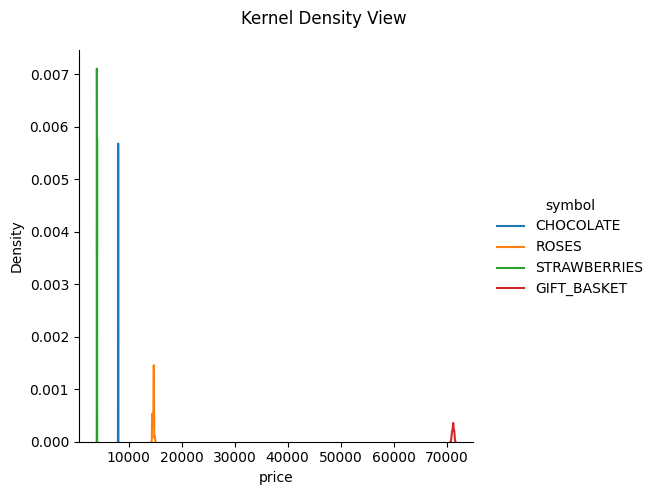

In [54]:
# Histograms with bins adjusted
g = sns.displot(df_day_0, x="price", hue="symbol", bins=9)
g.fig.suptitle("Overlaid Histograms")  # Use `fig.suptitle` for displot
g.fig.subplots_adjust(top=0.9)  # Adjust the title to not overlap with plots

# Kernel Density Estimate (KDE)
h = sns.displot(df_day_0, x="price", hue="symbol", kind="kde", bw_adjust=0.75)
h.fig.suptitle("Kernel Density View")
h.fig.subplots_adjust(top=0.9)

plt.show()

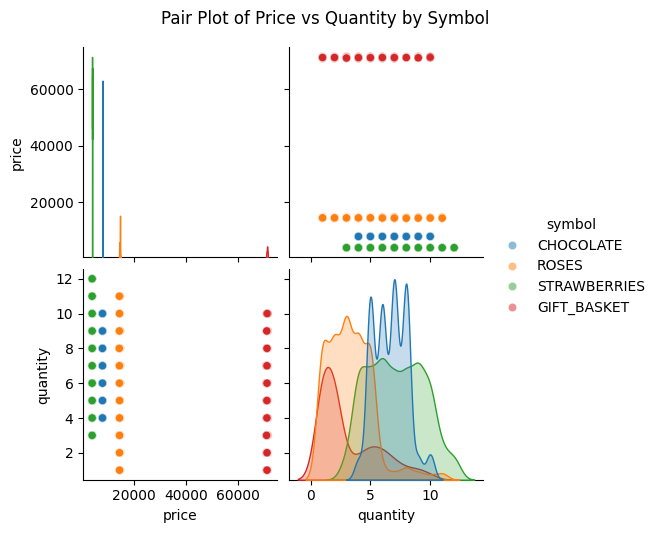

In [82]:
# Create a pair plot
pair_plot = sns.pairplot(
    df_day_0, vars=["price", "quantity"], hue="symbol", plot_kws={"alpha": 0.5}
)
pair_plot.fig.suptitle("Pair Plot of Price vs Quantity by Symbol", y=1.05)
plt.show()

## Modelling


In [64]:
# Creating new column for price * quantity
df_day_0["value"] = df_day_0["price"] * df_day_0["quantity"]
df_day_0

,timestamp,buyer,seller,symbol,currency,price,quantity,value
0,0,NaN,NaN,CHOCOLATE,SEASHELLS,8001.0,8,64008.0
1,0,NaN,NaN,ROSES,SEASHELLS,15001.0,3,45003.0
2,200,NaN,NaN,ROSES,SEASHELLS,15000.0,3,45000.0
3,500,NaN,NaN,STRAWBERRIES,SEASHELLS,3999.0,10,39990.0
4,1000,NaN,NaN,GIFT_BASKET,SEASHELLS,71360.0,2,142720.0
...,...,...,...,...,...,...,...,...
3850,999000,NaN,NaN,CHOCOLATE,SEASHELLS,7988.0,6,47928.0
3851,999200,NaN,NaN,STRAWBERRIES,SEASHELLS,4032.0,7,28224.0
3852,999200,NaN,NaN,CHOCOLATE,SEASHELLS,7989.0,8,63912.0
3853,999300,NaN,NaN,STRAWBERRIES,SEASHELLS,4032.0,4,16128.0


In [120]:
# Check if the pivot table operation is done correctly and resulting in data
pivot_df = df_day_0.pivot_table(
    index="timestamp",
    columns="symbol",
    values="price",
    aggfunc="mean",  # or 'sum', 'max' etc., based on your need
)
print(pivot_df.head(15))

symbol     CHOCOLATE  GIFT_BASKET    ROSES  STRAWBERRIES
timestamp                                               
0             8001.0          NaN  15001.0           NaN
200              NaN          NaN  15000.0           NaN
500              NaN          NaN      NaN        3999.0
1000             NaN      71360.0      NaN           NaN
1200             NaN          NaN  14997.0           NaN
1300          8000.0          NaN      NaN           NaN
1400             NaN          NaN  14994.0           NaN
2600             NaN          NaN  14974.0           NaN
2800             NaN          NaN      NaN        4001.0
3100             NaN          NaN  14961.0           NaN
3200             NaN          NaN      NaN        4002.0
3300             NaN          NaN      NaN        4001.0
3500          8005.0      71340.0      NaN        4000.0
3700             NaN          NaN  14955.0           NaN
3800             NaN      71339.0      NaN           NaN


symbol CHOCOLATE GIFT_BASKET ROSES STRAWBERRIES  
1000 8001.0 71360.0 15000.0 3999.0  
3500 8005.0 71340.0 14961.0 4000.0  
3800 8005.0 71339.0 14955.0 4000.0  
...


In [122]:
pivot_df = pivot_df.replace(r"^\s*$", pd.NA, regex=True)
pivot_df = pivot_df.astype(float)
pivot_df.head(15)

symbol,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,
0,8001.0,NaN,15001.0,NaN
200,NaN,NaN,15000.0,NaN
500,NaN,NaN,NaN,3999.0
1000,NaN,71360.0,NaN,NaN
1200,NaN,NaN,14997.0,NaN
1300,8000.0,NaN,NaN,NaN
1400,NaN,NaN,14994.0,NaN
2600,NaN,NaN,14974.0,NaN
2800,NaN,NaN,NaN,4001.0


In [102]:
# # Output DataFrame to collect the needed rows
# output_df = pd.DataFrame()
# reset_index = 0
# for index, row in pivot_df.iterrows():
#     if pd.notna(pivot_df.at[index, "GIFT_BASKET"]):
#         # Forward fill till this index
#         pivot_df.loc[reset_index:index] = (
#             pivot_df.loc[reset_index:index].ffill().bfill()
#         )
#         output_df = pd.concat([output_df, pivot_df.loc[[index]]])
#         reset_index = index + 1

# # Display the desired output
# output_df.dropna(axis=1, how="all", inplace=True)  # Drop columns if all values are NaN
# print(output_df)

symbol     CHOCOLATE  GIFT_BASKET    ROSES  STRAWBERRIES
timestamp                                               
1000          8001.0      71360.0  15000.0        3999.0
3500          8005.0      71340.0  14961.0        4000.0
3800             NaN      71339.0  14955.0           NaN
9500          8003.0      71386.0  14961.0        4003.0
13000         8004.0      71400.0  14933.0        4001.0
...              ...          ...      ...           ...
993400           NaN      71212.0      NaN           NaN
994600           NaN      71216.0  14577.0           NaN
996800        7997.0      71205.0  14572.0        4030.0
998100           NaN      71199.0  14570.0        4031.0
998500        7989.0      71196.0      NaN           NaN

[477 rows x 4 columns]


In [118]:
df = pivot_df.replace(r"^\s*$", pd.NA, regex=True)
df = pivot_df.astype(float)

# Output DataFrame to collect the needed rows
output_df = pd.DataFrame()

# Process the DataFrame
last_valid_gift_basket = None
for index, row in df.iterrows():
    if pd.notna(df.at[index, "GIFT_BASKET"]):
        # If a valid "GIFT_BASKET" price is found, update until this point and reset
        if last_valid_gift_basket is not None:
            # Apply ffill from the last valid "GIFT_BASKET" to the current index
            df.loc[last_valid_gift_basket:index] = df.loc[
                last_valid_gift_basket:index
            ].ffill()
            output_df = pd.concat([output_df, df.loc[[index]]])
        last_valid_gift_basket = index
    elif index == df.index[-1]:  # Check if this is the last row and needs processing
        df.loc[last_valid_gift_basket:index] = df.loc[
            last_valid_gift_basket:index
        ].ffill()
        output_df = pd.concat([output_df, df.loc[[index]]])

# Ensure the data does not have unwanted NaNs by forward filling from the last valid entry
output_df.ffill(inplace=True)

# Display the desired output
output_df.dropna(axis=1, how="all", inplace=True)  # Drop columns if all values are NaN
print(output_df)

symbol     CHOCOLATE  GIFT_BASKET    ROSES  STRAWBERRIES
timestamp                                               
3500          8005.0      71340.0  14961.0        4000.0
3800          8005.0      71339.0  14955.0        4000.0
9500          8003.0      71386.0  14961.0        4003.0
13000         8004.0      71400.0  14933.0        4001.0
13900         8006.0      71382.0  14934.0        4001.0
...              ...          ...      ...           ...
994600        7997.0      71216.0  14577.0        4030.0
996800        7997.0      71205.0  14572.0        4030.0
998100        7997.0      71199.0  14570.0        4031.0
998500        7989.0      71196.0  14570.0        4031.0
999800        7989.0      71196.0  14547.0        4032.0

[477 rows x 4 columns]


In [124]:
# Define the features and the target
X = output_df.drop("GIFT_BASKET", axis=1)
y = output_df["GIFT_BASKET"]
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

Ridge Regression


In [127]:
# Creating a Ridge regression model with standard scaling
ridge_model = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])

# Training the model
ridge_model.fit(X_train, y_train)

# Predicting the test set
ridge_predictions = ridge_model.predict(X_test)

# Evaluating the model
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("Ridge Regression MSE:", ridge_mse)

Ridge Regression MSE: 6928.5890445717605


Lasso Regression


In [141]:
# Creating a Lasso regression model with standard scaling
lasso_model = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.55))])

# Training the model
lasso_model.fit(X_train, y_train)

# Predicting the test set
lasso_predictions = lasso_model.predict(X_test)

# Evaluating the model
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("Lasso Regression MSE:", lasso_mse)

Lasso Regression MSE: 6926.827383429338


Polynomial Regression


In [129]:
# Creating a pipeline for polynomial regression
poly_model = Pipeline(
    [
        ("poly_features", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("linear_regression", LinearRegression()),
    ]
)

# Training the model
poly_model.fit(X_train, y_train)

# Predicting the test set
poly_predictions = poly_model.predict(X_test)

# Evaluating the model
poly_mse = mean_squared_error(y_test, poly_predictions)
print("Polynomial Regression MSE:", poly_mse)

Polynomial Regression MSE: 5678.20615208103


Scaling: Standardizing the features to improve model performance.  
Model Fitting: Using Ridge, Lasso, and Polynomial features within a linear regression context.  
Evaluation: Computing the Mean Squared Error (MSE) to assess model performance.

The use of Pipeline in Scikit-Learn helps in managing sequences of transformations and model training in a clean and efficient way. Adjust the parameters such as alpha for Ridge and Lasso, and the degree for PolynomialFeatures based on validation or cross-validation results to optimize model performance.


In [133]:
model = Pipeline(
    [
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("linear_regression", LinearRegression()),
    ]
)
model.fit(X, y)

# Get the coefficients and intercept
coef = model.named_steps["linear_regression"].coef_
intercept = model.named_steps["linear_regression"].intercept_

# Get feature names from PolynomialFeatures without specifying input features
feature_names = model.named_steps["poly_features"].get_feature_names_out()

# Construct the regression equation
terms = [
    f"{coef[i]:.2f}*{name}" for i, name in enumerate(feature_names) if coef[i] != 0
]
equation = " + ".join(terms)
equation = f"{intercept:.2f} + {equation}"

print("Regression Equation:")
print(equation)

Regression Equation:
71221.85 + 16625.01*CHOCOLATE + 537.83*ROSES + 2084.83*STRAWBERRIES + -9158.58*CHOCOLATE^2 + -4251.53*CHOCOLATE ROSES + -13854.89*CHOCOLATE STRAWBERRIES + 3403.51*ROSES^2 + 415.95*ROSES STRAWBERRIES + 11736.36*STRAWBERRIES^2
